# Algorithms for Threat Detection Data
By Zhonghao Zhao and Bingxue An, under advise of Professor Bo Li

In [2]:
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import math
import warnings

In [3]:
# read data
data_number = [1,2,3]
dataset = pd.read_csv("DATA/"+ "AIS_Challenge_Problem_Set_0_"+ str(1) + "_withVID.csv")
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13714 entries, 0 to 13713
Data columns (total 7 columns):
OBJECT_ID             13714 non-null int64
VID                   13714 non-null int64
SEQUENCE_DTTM         13714 non-null object
LAT                   13714 non-null float64
LON                   13714 non-null float64
SPEED_OVER_GROUND     13714 non-null int64
COURSE_OVER_GROUND    13714 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 750.1+ KB


,OBJECT_ID,VID,SEQUENCE_DTTM,LAT,LON,SPEED_OVER_GROUND,COURSE_OVER_GROUND
0,1,100008,14:00:00,36.906850,-76.089022,1,1641
1,2,100015,14:00:00,36.950000,-76.026834,11,2815
2,3,100016,14:00:00,36.906783,-76.089084,0,2632
3,4,100019,14:00:00,37.003000,-76.283167,148,2460
4,5,100016,14:00:01,36.906783,-76.089084,0,2632


In [4]:
# A method to convert HH-MM-SS to seconds
def get_sec(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

# a node class for each data
class Vessel_node:
    def __init__(self, object_id, time, lat, lon, speed, direction, real_VID):
        self.OBJECT_ID = object_id
        self.VID = -1
        self.Time = time
        self.LAT = lat
        self.LON = lon
        self.Speed = speed*0.514444
        self.Direction = direction
        self.real_vid = real_VID
    
    def set_VID(self, vid):
        self.VID = vid
    
    def get_ID(self):
        return self.OBJECT_ID
    
    def get_real_vid(self):
        return self.real_vid
    
    def get_LAT(self):
        return self.LAT
    
    def get_LON(self):
        return self.LON
    
    def get_Time(self):
        return self.Time
    
    def get_SPEED(self):
        return self.Speed
    
    def get_DIRECTION(self):
        return self.Direction
    
# a track class to keep all tracks
class All_tracks:
    def __init__(self):
        self.tracks = []
        self.total_track = 0
        self.node_tracks = []
    
    def get_total_track(self):
        return self.total_track
        
    def add_track(self, node):
        new_track = [node.get_ID()]
        new_node_track = [node]
        self.total_track += 1
        node.set_VID(self.total_track)
        self.tracks.append(new_track)
        self.node_tracks.append(new_node_track) 
     
    def add_node(self, track_id, node):
        node.set_VID(track_id)
        self.tracks[track_id - 1].append(node.get_ID())
        self.node_tracks[track_id - 1].append(node)
    
    def print_track(self):
        for track in self.tracks:
            print(track)
            print('\n')
        
    def print_track_number(self):
        print(self.total_track)
    
    def get_node_track(self):
        return self.node_tracks
    
    def get_track_number(self):
        return self.total_track
    
    def get_tracks(self):
        return self.tracks
'''The initial assumption is the accleration is constant between two nodes, use v_1-v_0 / (t_1-t_0) to calculate 
the accleration, use v_0*t + 0.5*a*t^2 to calculate the desired final x, y location, then compare it with the final 
x, y location, calculate the desired distance difference sqrt (x_expect-x)^2 + (y_expect-y)^2 for every track, compare
it with the actual distane, using actual lon and lat to calculate
'''
def calculate_distance(lat2, lon2, lat1, lon1):
    R = 6371000; #earth radian
    l_1 = math.radians(lat1)
    l_2 = math.radians(lat2)
    lat_diff = math.radians(lat2-lat1)
    lon_diff = math.radians(lon2-lon1)
    temp = math.sin(lat_diff/2)**2 + math.cos(l_1) * math.cos(l_2) * math.sin(lon_diff/2)**2
    c = 2 * math.atan2(math.sqrt(temp), math.sqrt(1-temp))
    d = R * c
    return d

''' This function will return the distance error between two nodes with the input of these two nodes
    distance error is defined as the square of error of (expected distance - actual distance)

'''

' This function will return the distance error between two nodes with the input of these two nodes\n    distance error is defined as the square of error of (expected distance - actual distance)\n\n'

In [5]:
'''Organize new training dataset for ML, determing when to start new track
   1 stands the two nodes are in same track, 0 stands not.
'''

vid = []
train_tracker = All_tracks()
speed_1 = []
speed_2 = []
Time_1 = []
Time_2 = []
Lat_1 = []
Lat_2 = []
Lon_1 = []
Lon_2 = []
angle_1 = []
angle_2 = []

outcome = []
prev_row = 0
prev_node = 0
for index, row in dataset.iterrows():
    #sequencial compare in general
    cur_row = row.tolist()
    cur_node = Vessel_node(cur_row[0],get_sec(cur_row[2]), cur_row[3], cur_row[4], cur_row[5]/10, cur_row[6]/10, cur_row[1])
    cur_vid = cur_row[1]
    if(prev_row):
        if cur_vid != prev_row[1]:
            speed_1.append(prev_node.get_SPEED())
            speed_2.append(cur_node.get_SPEED())
            Time_1.append(prev_node.get_Time())
            Time_2.append(cur_node.get_Time())
            Lat_1.append(prev_node.get_LAT())
            Lat_2.append(cur_node.get_LAT())      
            Lon_1.append(prev_node.get_LON())
            Lon_2.append(cur_node.get_LON())
            angle_1.append(prev_node.get_DIRECTION())
            angle_2.append(cur_node.get_DIRECTION())
            outcome.append(0)
            
    prev_row = cur_row
    prev_node = cur_node
    
    #sequencial compare in same track
    if(vid and (cur_vid in vid)):
        node_tracks = train_tracker.get_node_track()
        for i in range(train_tracker.get_track_number()):
            cur_track = node_tracks[i]
            last = cur_track[-1]
            if(last.get_real_vid() == cur_vid):
                train_tracker.add_node(i+1, cur_node)
                speed_1.append(last.get_SPEED())
                speed_2.append(cur_node.get_SPEED())
                Time_1.append(last.get_Time())
                Time_2.append(cur_node.get_Time())
                Lat_1.append(last.get_LAT())
                Lat_2.append(cur_node.get_LAT())      
                Lon_1.append(last.get_LON())
                Lon_2.append(cur_node.get_LON())
                angle_1.append(last.get_DIRECTION())
                angle_2.append(cur_node.get_DIRECTION())
                outcome.append(1)
            else:
                continue
    
    if(cur_vid not in vid):
        vid.append(cur_vid)
        train_tracker.add_track(cur_node)
        
"""
see whether we get a balanced training dataset 
"""
count_0 = 0
count_1 = 0
for item in outcome:
    if item == 0:
        count_0 += 1
    else:
        count_1 += 1
        
print(count_0, count_1)

13188 13694


In [9]:
zippedList =  list(zip(speed_1, speed_2, Time_1, Time_2, Lat_1, Lat_2, Lon_1, Lon_2, angle_1, angle_2,outcome))  
new_dataframe = pd.DataFrame(zippedList, columns = ["speed_1", "speed_2", "Time_1", "Time_2", "Lat_1", "Lat_2", "Lon_1", "Lon_2", 
                                                    "angle_1", "angle_2","outcome"])

In [13]:
new_dataframe.head()

,speed_1,speed_2,Time_1,Time_2,Lat_1,Lat_2,Lon_1,Lon_2,angle_1,angle_2,outcome
0,0.051444,0.565888,50400,50400,36.906850,36.950000,-76.089022,-76.026834,164.1,281.5,0
1,0.565888,0.000000,50400,50400,36.950000,36.906783,-76.026834,-76.089084,281.5,263.2,0
2,0.000000,7.613771,50400,50400,36.906783,37.003000,-76.089084,-76.283167,263.2,246.0,0
3,7.613771,0.000000,50400,50401,37.003000,36.906783,-76.283167,-76.089084,246.0,263.2,0
4,0.000000,0.000000,50400,50401,36.906783,36.906783,-76.089084,-76.089084,263.2,263.2,1


In [15]:
response = np.asarray(outcome)
print(response)

[0 0 0 ... 1 0 1]


In [39]:
#k fold cross validation, k = 10, 0 not same track, 1 same
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier # Import Random Forest Classifier
from sklearn.model_selection import train_test_split
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
randomForest_scores = []
best_randomForest = 0
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(new_dataframe.drop(['outcome'], axis = "columns"),
                                                        response, test_size = 0.2)
    model = RandomForestClassifier(n_estimators= 20)
    model.fit(X_train, y_train)
    current_score_r = model.score(X_test,y_test)
    if not randomForest_scores or current_score_r > max(randomForest_scores):
        best_randomForest = model
    randomForest_scores.append(current_score_r)

In [40]:
best_randomForest.score(X_test,y_test)

0.9996280453784638

In [41]:
feature_importances = pd.DataFrame(best_randomForest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

         importance
Lon_2      0.200970
Lat_2      0.154756
Lon_1      0.152795
Lat_1      0.151414
angle_2    0.084117
speed_2    0.082798
speed_1    0.078425
angle_1    0.065765
Time_2     0.014642
Time_1     0.014318


In [65]:
''' This function will return the distance error between two nodes with the input of these two nodes
    distance error is defined as the square of error of (expected distance - actual distance)

'''

def calculate_DE(node_a, node_b):
    a = node_a
    b = node_b
    angle_1 = math.radians(a.get_DIRECTION())
    angle_2 = math.radians(b.get_DIRECTION())
    v_diff_x = b.get_SPEED()*math.cos(angle_2) - a.get_SPEED()*math.cos(angle_1)
    v_diff_y = b.get_SPEED()*math.sin(angle_2) - a.get_SPEED()*math.sin(angle_1)
    t_diff = b.get_Time()- a.get_Time()
    acc_x = v_diff_x / t_diff
    acc_y = v_diff_y / t_diff
    lon_diff_expect = a.get_SPEED()*math.cos(angle_1)*t_diff + 0.5*acc_x*t_diff**2
    lat_diff_expect = a.get_SPEED()*math.sin(angle_1)*t_diff + 0.5*acc_y*t_diff**2
    total_diff = math.sqrt(lon_diff_expect**2 + lat_diff_expect**2)
    d = calculate_distance(b.get_LAT(), b.get_LON(), a.get_LAT(), b.get_LON())
    error = (abs(d)-abs(total_diff))**2
    return error

def sortSecond(val): 
    return val[1]  

new_tracker = All_tracks()
for index, row in dataset.iterrows():
    a = row.tolist()
    cur_node = Vessel_node(a[0],get_sec(a[2]), a[3], a[4], a[5]/10, a[6]/10,a[1])
    print(">>> processing row " + str(index))
    if(index == 0):
        new_tracker.add_track(cur_node)
    else:
        all_possible = []
        node_tracks = new_tracker.get_node_track()
        for i in range(new_tracker.get_track_number()):
            each_track = node_tracks[i]
            last_node = each_track[-1]
            df = [[last_node.get_SPEED(), cur_node.get_SPEED(), last_node.get_Time(), cur_node.get_Time(), 
            last_node.get_LAT(), cur_node.get_LAT(), last_node.get_LON(), cur_node.get_LON(), last_node.get_DIRECTION(),
            cur_node.get_DIRECTION()]]
            if best_randomForest.predict(df) == 1 and last_node.get_Time() != cur_node.get_Time():
                error = calculate_DE(last_node, cur_node)
                all_possible.append((i+1, error))
                
        if not all_possible:
            new_tracker.add_track(cur_node)
        else:
            all_possible.sort(key = sortSecond)
            new_tracker.add_node(all_possible[0][0], cur_node)

new_tracker.print_track_number()

>>> processing row 0
>>> processing row 1
>>> processing row 2
>>> processing row 3
>>> processing row 4
>>> processing row 5
>>> processing row 6
>>> processing row 7
>>> processing row 8
>>> processing row 9
>>> processing row 10
>>> processing row 11
>>> processing row 12
>>> processing row 13
>>> processing row 14
>>> processing row 15
>>> processing row 16
>>> processing row 17
>>> processing row 18
>>> processing row 19
>>> processing row 20
>>> processing row 21
>>> processing row 22
>>> processing row 23
>>> processing row 24
>>> processing row 25
>>> processing row 26
>>> processing row 27
>>> processing row 28
>>> processing row 29
>>> processing row 30
>>> processing row 31
>>> processing row 32
>>> processing row 33
>>> processing row 34
>>> processing row 35
>>> processing row 36
>>> processing row 37
>>> processing row 38
>>> processing row 39
>>> processing row 40
>>> processing row 41
>>> processing row 42
>>> processing row 43
>>> processing row 44
>>> processing row 4

>>> processing row 367
>>> processing row 368
>>> processing row 369
>>> processing row 370
>>> processing row 371
>>> processing row 372
>>> processing row 373
>>> processing row 374
>>> processing row 375
>>> processing row 376
>>> processing row 377
>>> processing row 378
>>> processing row 379
>>> processing row 380
>>> processing row 381
>>> processing row 382
>>> processing row 383
>>> processing row 384
>>> processing row 385
>>> processing row 386
>>> processing row 387
>>> processing row 388
>>> processing row 389
>>> processing row 390
>>> processing row 391
>>> processing row 392
>>> processing row 393
>>> processing row 394
>>> processing row 395
>>> processing row 396
>>> processing row 397
>>> processing row 398
>>> processing row 399
>>> processing row 400
>>> processing row 401
>>> processing row 402
>>> processing row 403
>>> processing row 404
>>> processing row 405
>>> processing row 406
>>> processing row 407
>>> processing row 408
>>> processing row 409
>>> process

>>> processing row 725
>>> processing row 726
>>> processing row 727
>>> processing row 728
>>> processing row 729
>>> processing row 730
>>> processing row 731
>>> processing row 732
>>> processing row 733
>>> processing row 734
>>> processing row 735
>>> processing row 736
>>> processing row 737
>>> processing row 738
>>> processing row 739
>>> processing row 740
>>> processing row 741
>>> processing row 742
>>> processing row 743
>>> processing row 744
>>> processing row 745
>>> processing row 746
>>> processing row 747
>>> processing row 748
>>> processing row 749
>>> processing row 750
>>> processing row 751
>>> processing row 752
>>> processing row 753
>>> processing row 754
>>> processing row 755
>>> processing row 756
>>> processing row 757
>>> processing row 758
>>> processing row 759
>>> processing row 760
>>> processing row 761
>>> processing row 762
>>> processing row 763
>>> processing row 764
>>> processing row 765
>>> processing row 766
>>> processing row 767
>>> process

>>> processing row 1087
>>> processing row 1088
>>> processing row 1089
>>> processing row 1090
>>> processing row 1091
>>> processing row 1092
>>> processing row 1093
>>> processing row 1094
>>> processing row 1095
>>> processing row 1096
>>> processing row 1097
>>> processing row 1098
>>> processing row 1099
>>> processing row 1100
>>> processing row 1101
>>> processing row 1102
>>> processing row 1103
>>> processing row 1104
>>> processing row 1105
>>> processing row 1106
>>> processing row 1107
>>> processing row 1108
>>> processing row 1109
>>> processing row 1110
>>> processing row 1111
>>> processing row 1112
>>> processing row 1113
>>> processing row 1114
>>> processing row 1115
>>> processing row 1116
>>> processing row 1117
>>> processing row 1118
>>> processing row 1119
>>> processing row 1120
>>> processing row 1121
>>> processing row 1122
>>> processing row 1123
>>> processing row 1124
>>> processing row 1125
>>> processing row 1126
>>> processing row 1127
>>> processing r

>>> processing row 1429
>>> processing row 1430
>>> processing row 1431
>>> processing row 1432
>>> processing row 1433
>>> processing row 1434
>>> processing row 1435
>>> processing row 1436
>>> processing row 1437
>>> processing row 1438
>>> processing row 1439
>>> processing row 1440
>>> processing row 1441
>>> processing row 1442
>>> processing row 1443
>>> processing row 1444
>>> processing row 1445
>>> processing row 1446
>>> processing row 1447
>>> processing row 1448
>>> processing row 1449
>>> processing row 1450
>>> processing row 1451
>>> processing row 1452
>>> processing row 1453
>>> processing row 1454
>>> processing row 1455
>>> processing row 1456
>>> processing row 1457
>>> processing row 1458
>>> processing row 1459
>>> processing row 1460
>>> processing row 1461
>>> processing row 1462
>>> processing row 1463
>>> processing row 1464
>>> processing row 1465
>>> processing row 1466
>>> processing row 1467
>>> processing row 1468
>>> processing row 1469
>>> processing r

>>> processing row 1773
>>> processing row 1774
>>> processing row 1775
>>> processing row 1776
>>> processing row 1777
>>> processing row 1778
>>> processing row 1779
>>> processing row 1780
>>> processing row 1781
>>> processing row 1782
>>> processing row 1783
>>> processing row 1784
>>> processing row 1785
>>> processing row 1786
>>> processing row 1787
>>> processing row 1788
>>> processing row 1789
>>> processing row 1790
>>> processing row 1791
>>> processing row 1792
>>> processing row 1793
>>> processing row 1794
>>> processing row 1795
>>> processing row 1796
>>> processing row 1797
>>> processing row 1798
>>> processing row 1799
>>> processing row 1800
>>> processing row 1801
>>> processing row 1802
>>> processing row 1803
>>> processing row 1804
>>> processing row 1805
>>> processing row 1806
>>> processing row 1807
>>> processing row 1808
>>> processing row 1809
>>> processing row 1810
>>> processing row 1811
>>> processing row 1812
>>> processing row 1813
>>> processing r

>>> processing row 2119
>>> processing row 2120
>>> processing row 2121
>>> processing row 2122
>>> processing row 2123
>>> processing row 2124
>>> processing row 2125
>>> processing row 2126
>>> processing row 2127
>>> processing row 2128
>>> processing row 2129
>>> processing row 2130
>>> processing row 2131
>>> processing row 2132
>>> processing row 2133
>>> processing row 2134
>>> processing row 2135
>>> processing row 2136
>>> processing row 2137
>>> processing row 2138
>>> processing row 2139
>>> processing row 2140
>>> processing row 2141
>>> processing row 2142
>>> processing row 2143
>>> processing row 2144
>>> processing row 2145
>>> processing row 2146
>>> processing row 2147
>>> processing row 2148
>>> processing row 2149
>>> processing row 2150
>>> processing row 2151
>>> processing row 2152
>>> processing row 2153
>>> processing row 2154
>>> processing row 2155
>>> processing row 2156
>>> processing row 2157
>>> processing row 2158
>>> processing row 2159
>>> processing r

>>> processing row 2460
>>> processing row 2461
>>> processing row 2462
>>> processing row 2463
>>> processing row 2464
>>> processing row 2465
>>> processing row 2466
>>> processing row 2467
>>> processing row 2468
>>> processing row 2469
>>> processing row 2470
>>> processing row 2471
>>> processing row 2472
>>> processing row 2473
>>> processing row 2474
>>> processing row 2475
>>> processing row 2476
>>> processing row 2477
>>> processing row 2478
>>> processing row 2479
>>> processing row 2480
>>> processing row 2481
>>> processing row 2482
>>> processing row 2483
>>> processing row 2484
>>> processing row 2485
>>> processing row 2486
>>> processing row 2487
>>> processing row 2488
>>> processing row 2489
>>> processing row 2490
>>> processing row 2491
>>> processing row 2492
>>> processing row 2493
>>> processing row 2494
>>> processing row 2495
>>> processing row 2496
>>> processing row 2497
>>> processing row 2498
>>> processing row 2499
>>> processing row 2500
>>> processing r

>>> processing row 2803
>>> processing row 2804
>>> processing row 2805
>>> processing row 2806
>>> processing row 2807
>>> processing row 2808
>>> processing row 2809
>>> processing row 2810
>>> processing row 2811
>>> processing row 2812
>>> processing row 2813
>>> processing row 2814
>>> processing row 2815
>>> processing row 2816
>>> processing row 2817
>>> processing row 2818
>>> processing row 2819
>>> processing row 2820
>>> processing row 2821
>>> processing row 2822
>>> processing row 2823
>>> processing row 2824
>>> processing row 2825
>>> processing row 2826
>>> processing row 2827
>>> processing row 2828
>>> processing row 2829
>>> processing row 2830
>>> processing row 2831
>>> processing row 2832
>>> processing row 2833
>>> processing row 2834
>>> processing row 2835
>>> processing row 2836
>>> processing row 2837
>>> processing row 2838
>>> processing row 2839
>>> processing row 2840
>>> processing row 2841
>>> processing row 2842
>>> processing row 2843
>>> processing r

>>> processing row 3147
>>> processing row 3148
>>> processing row 3149
>>> processing row 3150
>>> processing row 3151
>>> processing row 3152
>>> processing row 3153
>>> processing row 3154
>>> processing row 3155
>>> processing row 3156
>>> processing row 3157
>>> processing row 3158
>>> processing row 3159
>>> processing row 3160
>>> processing row 3161
>>> processing row 3162
>>> processing row 3163
>>> processing row 3164
>>> processing row 3165
>>> processing row 3166
>>> processing row 3167
>>> processing row 3168
>>> processing row 3169
>>> processing row 3170
>>> processing row 3171
>>> processing row 3172
>>> processing row 3173
>>> processing row 3174
>>> processing row 3175
>>> processing row 3176
>>> processing row 3177
>>> processing row 3178
>>> processing row 3179
>>> processing row 3180
>>> processing row 3181
>>> processing row 3182
>>> processing row 3183
>>> processing row 3184
>>> processing row 3185
>>> processing row 3186
>>> processing row 3187
>>> processing r

>>> processing row 3492
>>> processing row 3493
>>> processing row 3494
>>> processing row 3495
>>> processing row 3496
>>> processing row 3497
>>> processing row 3498
>>> processing row 3499
>>> processing row 3500
>>> processing row 3501
>>> processing row 3502
>>> processing row 3503
>>> processing row 3504
>>> processing row 3505
>>> processing row 3506
>>> processing row 3507
>>> processing row 3508
>>> processing row 3509
>>> processing row 3510
>>> processing row 3511
>>> processing row 3512
>>> processing row 3513
>>> processing row 3514
>>> processing row 3515
>>> processing row 3516
>>> processing row 3517
>>> processing row 3518
>>> processing row 3519
>>> processing row 3520
>>> processing row 3521
>>> processing row 3522
>>> processing row 3523
>>> processing row 3524
>>> processing row 3525
>>> processing row 3526
>>> processing row 3527
>>> processing row 3528
>>> processing row 3529
>>> processing row 3530
>>> processing row 3531
>>> processing row 3532
>>> processing r

>>> processing row 3836
>>> processing row 3837
>>> processing row 3838
>>> processing row 3839
>>> processing row 3840
>>> processing row 3841
>>> processing row 3842
>>> processing row 3843
>>> processing row 3844
>>> processing row 3845
>>> processing row 3846
>>> processing row 3847
>>> processing row 3848
>>> processing row 3849
>>> processing row 3850
>>> processing row 3851
>>> processing row 3852
>>> processing row 3853
>>> processing row 3854
>>> processing row 3855
>>> processing row 3856
>>> processing row 3857
>>> processing row 3858
>>> processing row 3859
>>> processing row 3860
>>> processing row 3861
>>> processing row 3862
>>> processing row 3863
>>> processing row 3864
>>> processing row 3865
>>> processing row 3866
>>> processing row 3867
>>> processing row 3868
>>> processing row 3869
>>> processing row 3870
>>> processing row 3871
>>> processing row 3872
>>> processing row 3873
>>> processing row 3874
>>> processing row 3875
>>> processing row 3876
>>> processing r

>>> processing row 4180
>>> processing row 4181
>>> processing row 4182
>>> processing row 4183
>>> processing row 4184
>>> processing row 4185
>>> processing row 4186
>>> processing row 4187
>>> processing row 4188
>>> processing row 4189
>>> processing row 4190
>>> processing row 4191
>>> processing row 4192
>>> processing row 4193
>>> processing row 4194
>>> processing row 4195
>>> processing row 4196
>>> processing row 4197
>>> processing row 4198
>>> processing row 4199
>>> processing row 4200
>>> processing row 4201
>>> processing row 4202
>>> processing row 4203
>>> processing row 4204
>>> processing row 4205
>>> processing row 4206
>>> processing row 4207
>>> processing row 4208
>>> processing row 4209
>>> processing row 4210
>>> processing row 4211
>>> processing row 4212
>>> processing row 4213
>>> processing row 4214
>>> processing row 4215
>>> processing row 4216
>>> processing row 4217
>>> processing row 4218
>>> processing row 4219
>>> processing row 4220
>>> processing r

>>> processing row 4524
>>> processing row 4525
>>> processing row 4526
>>> processing row 4527
>>> processing row 4528
>>> processing row 4529
>>> processing row 4530
>>> processing row 4531
>>> processing row 4532
>>> processing row 4533
>>> processing row 4534
>>> processing row 4535
>>> processing row 4536
>>> processing row 4537
>>> processing row 4538
>>> processing row 4539
>>> processing row 4540
>>> processing row 4541
>>> processing row 4542
>>> processing row 4543
>>> processing row 4544
>>> processing row 4545
>>> processing row 4546
>>> processing row 4547
>>> processing row 4548
>>> processing row 4549
>>> processing row 4550
>>> processing row 4551
>>> processing row 4552
>>> processing row 4553
>>> processing row 4554
>>> processing row 4555
>>> processing row 4556
>>> processing row 4557
>>> processing row 4558
>>> processing row 4559
>>> processing row 4560
>>> processing row 4561
>>> processing row 4562
>>> processing row 4563
>>> processing row 4564
>>> processing r

>>> processing row 4868
>>> processing row 4869
>>> processing row 4870
>>> processing row 4871
>>> processing row 4872
>>> processing row 4873
>>> processing row 4874
>>> processing row 4875
>>> processing row 4876
>>> processing row 4877
>>> processing row 4878
>>> processing row 4879
>>> processing row 4880
>>> processing row 4881
>>> processing row 4882
>>> processing row 4883
>>> processing row 4884
>>> processing row 4885
>>> processing row 4886
>>> processing row 4887
>>> processing row 4888
>>> processing row 4889
>>> processing row 4890
>>> processing row 4891
>>> processing row 4892
>>> processing row 4893
>>> processing row 4894
>>> processing row 4895
>>> processing row 4896
>>> processing row 4897
>>> processing row 4898
>>> processing row 4899
>>> processing row 4900
>>> processing row 4901
>>> processing row 4902
>>> processing row 4903
>>> processing row 4904
>>> processing row 4905
>>> processing row 4906
>>> processing row 4907
>>> processing row 4908
>>> processing r

>>> processing row 5213
>>> processing row 5214
>>> processing row 5215
>>> processing row 5216
>>> processing row 5217
>>> processing row 5218
>>> processing row 5219
>>> processing row 5220
>>> processing row 5221
>>> processing row 5222
>>> processing row 5223
>>> processing row 5224
>>> processing row 5225
>>> processing row 5226
>>> processing row 5227
>>> processing row 5228
>>> processing row 5229
>>> processing row 5230
>>> processing row 5231
>>> processing row 5232
>>> processing row 5233
>>> processing row 5234
>>> processing row 5235
>>> processing row 5236
>>> processing row 5237
>>> processing row 5238
>>> processing row 5239
>>> processing row 5240
>>> processing row 5241
>>> processing row 5242
>>> processing row 5243
>>> processing row 5244
>>> processing row 5245
>>> processing row 5246
>>> processing row 5247
>>> processing row 5248
>>> processing row 5249
>>> processing row 5250
>>> processing row 5251
>>> processing row 5252
>>> processing row 5253
>>> processing r

>>> processing row 5557
>>> processing row 5558
>>> processing row 5559
>>> processing row 5560
>>> processing row 5561
>>> processing row 5562
>>> processing row 5563
>>> processing row 5564
>>> processing row 5565
>>> processing row 5566
>>> processing row 5567
>>> processing row 5568
>>> processing row 5569
>>> processing row 5570
>>> processing row 5571
>>> processing row 5572
>>> processing row 5573
>>> processing row 5574
>>> processing row 5575
>>> processing row 5576
>>> processing row 5577
>>> processing row 5578
>>> processing row 5579
>>> processing row 5580
>>> processing row 5581
>>> processing row 5582
>>> processing row 5583
>>> processing row 5584
>>> processing row 5585
>>> processing row 5586
>>> processing row 5587
>>> processing row 5588
>>> processing row 5589
>>> processing row 5590
>>> processing row 5591
>>> processing row 5592
>>> processing row 5593
>>> processing row 5594
>>> processing row 5595
>>> processing row 5596
>>> processing row 5597
>>> processing r

>>> processing row 5899
>>> processing row 5900
>>> processing row 5901
>>> processing row 5902
>>> processing row 5903
>>> processing row 5904
>>> processing row 5905
>>> processing row 5906
>>> processing row 5907
>>> processing row 5908
>>> processing row 5909
>>> processing row 5910
>>> processing row 5911
>>> processing row 5912
>>> processing row 5913
>>> processing row 5914
>>> processing row 5915
>>> processing row 5916
>>> processing row 5917
>>> processing row 5918
>>> processing row 5919
>>> processing row 5920
>>> processing row 5921
>>> processing row 5922
>>> processing row 5923
>>> processing row 5924
>>> processing row 5925
>>> processing row 5926
>>> processing row 5927
>>> processing row 5928
>>> processing row 5929
>>> processing row 5930
>>> processing row 5931
>>> processing row 5932
>>> processing row 5933
>>> processing row 5934
>>> processing row 5935
>>> processing row 5936
>>> processing row 5937
>>> processing row 5938
>>> processing row 5939
>>> processing r

>>> processing row 6242
>>> processing row 6243
>>> processing row 6244
>>> processing row 6245
>>> processing row 6246
>>> processing row 6247
>>> processing row 6248
>>> processing row 6249
>>> processing row 6250
>>> processing row 6251
>>> processing row 6252
>>> processing row 6253
>>> processing row 6254
>>> processing row 6255
>>> processing row 6256
>>> processing row 6257
>>> processing row 6258
>>> processing row 6259
>>> processing row 6260
>>> processing row 6261
>>> processing row 6262
>>> processing row 6263
>>> processing row 6264
>>> processing row 6265
>>> processing row 6266
>>> processing row 6267
>>> processing row 6268
>>> processing row 6269
>>> processing row 6270
>>> processing row 6271
>>> processing row 6272
>>> processing row 6273
>>> processing row 6274
>>> processing row 6275
>>> processing row 6276
>>> processing row 6277
>>> processing row 6278
>>> processing row 6279
>>> processing row 6280
>>> processing row 6281
>>> processing row 6282
>>> processing r

>>> processing row 6584
>>> processing row 6585
>>> processing row 6586
>>> processing row 6587
>>> processing row 6588
>>> processing row 6589
>>> processing row 6590
>>> processing row 6591
>>> processing row 6592
>>> processing row 6593
>>> processing row 6594
>>> processing row 6595
>>> processing row 6596
>>> processing row 6597
>>> processing row 6598
>>> processing row 6599
>>> processing row 6600
>>> processing row 6601
>>> processing row 6602
>>> processing row 6603
>>> processing row 6604
>>> processing row 6605
>>> processing row 6606
>>> processing row 6607
>>> processing row 6608
>>> processing row 6609
>>> processing row 6610
>>> processing row 6611
>>> processing row 6612
>>> processing row 6613
>>> processing row 6614
>>> processing row 6615
>>> processing row 6616
>>> processing row 6617
>>> processing row 6618
>>> processing row 6619
>>> processing row 6620
>>> processing row 6621
>>> processing row 6622
>>> processing row 6623
>>> processing row 6624
>>> processing r

>>> processing row 6926
>>> processing row 6927
>>> processing row 6928
>>> processing row 6929
>>> processing row 6930
>>> processing row 6931
>>> processing row 6932
>>> processing row 6933
>>> processing row 6934
>>> processing row 6935
>>> processing row 6936
>>> processing row 6937
>>> processing row 6938
>>> processing row 6939
>>> processing row 6940
>>> processing row 6941
>>> processing row 6942
>>> processing row 6943
>>> processing row 6944
>>> processing row 6945
>>> processing row 6946
>>> processing row 6947
>>> processing row 6948
>>> processing row 6949
>>> processing row 6950
>>> processing row 6951
>>> processing row 6952
>>> processing row 6953
>>> processing row 6954
>>> processing row 6955
>>> processing row 6956
>>> processing row 6957
>>> processing row 6958
>>> processing row 6959
>>> processing row 6960
>>> processing row 6961
>>> processing row 6962
>>> processing row 6963
>>> processing row 6964
>>> processing row 6965
>>> processing row 6966
>>> processing r

>>> processing row 7269
>>> processing row 7270
>>> processing row 7271
>>> processing row 7272
>>> processing row 7273
>>> processing row 7274
>>> processing row 7275
>>> processing row 7276
>>> processing row 7277
>>> processing row 7278
>>> processing row 7279
>>> processing row 7280
>>> processing row 7281
>>> processing row 7282
>>> processing row 7283
>>> processing row 7284
>>> processing row 7285
>>> processing row 7286
>>> processing row 7287
>>> processing row 7288
>>> processing row 7289
>>> processing row 7290
>>> processing row 7291
>>> processing row 7292
>>> processing row 7293
>>> processing row 7294
>>> processing row 7295
>>> processing row 7296
>>> processing row 7297
>>> processing row 7298
>>> processing row 7299
>>> processing row 7300
>>> processing row 7301
>>> processing row 7302
>>> processing row 7303
>>> processing row 7304
>>> processing row 7305
>>> processing row 7306
>>> processing row 7307
>>> processing row 7308
>>> processing row 7309
>>> processing r

>>> processing row 7611
>>> processing row 7612
>>> processing row 7613
>>> processing row 7614
>>> processing row 7615
>>> processing row 7616
>>> processing row 7617
>>> processing row 7618
>>> processing row 7619
>>> processing row 7620
>>> processing row 7621
>>> processing row 7622
>>> processing row 7623
>>> processing row 7624
>>> processing row 7625
>>> processing row 7626
>>> processing row 7627
>>> processing row 7628
>>> processing row 7629
>>> processing row 7630
>>> processing row 7631
>>> processing row 7632
>>> processing row 7633
>>> processing row 7634
>>> processing row 7635
>>> processing row 7636
>>> processing row 7637
>>> processing row 7638
>>> processing row 7639
>>> processing row 7640
>>> processing row 7641
>>> processing row 7642
>>> processing row 7643
>>> processing row 7644
>>> processing row 7645
>>> processing row 7646
>>> processing row 7647
>>> processing row 7648
>>> processing row 7649
>>> processing row 7650
>>> processing row 7651
>>> processing r

>>> processing row 7954
>>> processing row 7955
>>> processing row 7956
>>> processing row 7957
>>> processing row 7958
>>> processing row 7959
>>> processing row 7960
>>> processing row 7961
>>> processing row 7962
>>> processing row 7963
>>> processing row 7964
>>> processing row 7965
>>> processing row 7966
>>> processing row 7967
>>> processing row 7968
>>> processing row 7969
>>> processing row 7970
>>> processing row 7971
>>> processing row 7972
>>> processing row 7973
>>> processing row 7974
>>> processing row 7975
>>> processing row 7976
>>> processing row 7977
>>> processing row 7978
>>> processing row 7979
>>> processing row 7980
>>> processing row 7981
>>> processing row 7982
>>> processing row 7983
>>> processing row 7984
>>> processing row 7985
>>> processing row 7986
>>> processing row 7987
>>> processing row 7988
>>> processing row 7989
>>> processing row 7990
>>> processing row 7991
>>> processing row 7992
>>> processing row 7993
>>> processing row 7994
>>> processing r

>>> processing row 8296
>>> processing row 8297
>>> processing row 8298
>>> processing row 8299
>>> processing row 8300
>>> processing row 8301
>>> processing row 8302
>>> processing row 8303
>>> processing row 8304
>>> processing row 8305
>>> processing row 8306
>>> processing row 8307
>>> processing row 8308
>>> processing row 8309
>>> processing row 8310
>>> processing row 8311
>>> processing row 8312
>>> processing row 8313
>>> processing row 8314
>>> processing row 8315
>>> processing row 8316
>>> processing row 8317
>>> processing row 8318
>>> processing row 8319
>>> processing row 8320
>>> processing row 8321
>>> processing row 8322
>>> processing row 8323
>>> processing row 8324
>>> processing row 8325
>>> processing row 8326
>>> processing row 8327
>>> processing row 8328
>>> processing row 8329
>>> processing row 8330
>>> processing row 8331
>>> processing row 8332
>>> processing row 8333
>>> processing row 8334
>>> processing row 8335
>>> processing row 8336
>>> processing r

>>> processing row 8640
>>> processing row 8641
>>> processing row 8642
>>> processing row 8643
>>> processing row 8644
>>> processing row 8645
>>> processing row 8646
>>> processing row 8647
>>> processing row 8648
>>> processing row 8649
>>> processing row 8650
>>> processing row 8651
>>> processing row 8652
>>> processing row 8653
>>> processing row 8654
>>> processing row 8655
>>> processing row 8656
>>> processing row 8657
>>> processing row 8658
>>> processing row 8659
>>> processing row 8660
>>> processing row 8661
>>> processing row 8662
>>> processing row 8663
>>> processing row 8664
>>> processing row 8665
>>> processing row 8666
>>> processing row 8667
>>> processing row 8668
>>> processing row 8669
>>> processing row 8670
>>> processing row 8671
>>> processing row 8672
>>> processing row 8673
>>> processing row 8674
>>> processing row 8675
>>> processing row 8676
>>> processing row 8677
>>> processing row 8678
>>> processing row 8679
>>> processing row 8680
>>> processing r

>>> processing row 8984
>>> processing row 8985
>>> processing row 8986
>>> processing row 8987
>>> processing row 8988
>>> processing row 8989
>>> processing row 8990
>>> processing row 8991
>>> processing row 8992
>>> processing row 8993
>>> processing row 8994
>>> processing row 8995
>>> processing row 8996
>>> processing row 8997
>>> processing row 8998
>>> processing row 8999
>>> processing row 9000
>>> processing row 9001
>>> processing row 9002
>>> processing row 9003
>>> processing row 9004
>>> processing row 9005
>>> processing row 9006
>>> processing row 9007
>>> processing row 9008
>>> processing row 9009
>>> processing row 9010
>>> processing row 9011
>>> processing row 9012
>>> processing row 9013
>>> processing row 9014
>>> processing row 9015
>>> processing row 9016
>>> processing row 9017
>>> processing row 9018
>>> processing row 9019
>>> processing row 9020
>>> processing row 9021
>>> processing row 9022
>>> processing row 9023
>>> processing row 9024
>>> processing r

>>> processing row 9327
>>> processing row 9328
>>> processing row 9329
>>> processing row 9330
>>> processing row 9331
>>> processing row 9332
>>> processing row 9333
>>> processing row 9334
>>> processing row 9335
>>> processing row 9336
>>> processing row 9337
>>> processing row 9338
>>> processing row 9339
>>> processing row 9340
>>> processing row 9341
>>> processing row 9342
>>> processing row 9343
>>> processing row 9344
>>> processing row 9345
>>> processing row 9346
>>> processing row 9347
>>> processing row 9348
>>> processing row 9349
>>> processing row 9350
>>> processing row 9351
>>> processing row 9352
>>> processing row 9353
>>> processing row 9354
>>> processing row 9355
>>> processing row 9356
>>> processing row 9357
>>> processing row 9358
>>> processing row 9359
>>> processing row 9360
>>> processing row 9361
>>> processing row 9362
>>> processing row 9363
>>> processing row 9364
>>> processing row 9365
>>> processing row 9366
>>> processing row 9367
>>> processing r

>>> processing row 9670
>>> processing row 9671
>>> processing row 9672
>>> processing row 9673
>>> processing row 9674
>>> processing row 9675
>>> processing row 9676
>>> processing row 9677
>>> processing row 9678
>>> processing row 9679
>>> processing row 9680
>>> processing row 9681
>>> processing row 9682
>>> processing row 9683
>>> processing row 9684
>>> processing row 9685
>>> processing row 9686
>>> processing row 9687
>>> processing row 9688
>>> processing row 9689
>>> processing row 9690
>>> processing row 9691
>>> processing row 9692
>>> processing row 9693
>>> processing row 9694
>>> processing row 9695
>>> processing row 9696
>>> processing row 9697
>>> processing row 9698
>>> processing row 9699
>>> processing row 9700
>>> processing row 9701
>>> processing row 9702
>>> processing row 9703
>>> processing row 9704
>>> processing row 9705
>>> processing row 9706
>>> processing row 9707
>>> processing row 9708
>>> processing row 9709
>>> processing row 9710
>>> processing r

>>> processing row 10012
>>> processing row 10013
>>> processing row 10014
>>> processing row 10015
>>> processing row 10016
>>> processing row 10017
>>> processing row 10018
>>> processing row 10019
>>> processing row 10020
>>> processing row 10021
>>> processing row 10022
>>> processing row 10023
>>> processing row 10024
>>> processing row 10025
>>> processing row 10026
>>> processing row 10027
>>> processing row 10028
>>> processing row 10029
>>> processing row 10030
>>> processing row 10031
>>> processing row 10032
>>> processing row 10033
>>> processing row 10034
>>> processing row 10035
>>> processing row 10036
>>> processing row 10037
>>> processing row 10038
>>> processing row 10039
>>> processing row 10040
>>> processing row 10041
>>> processing row 10042
>>> processing row 10043
>>> processing row 10044
>>> processing row 10045
>>> processing row 10046
>>> processing row 10047
>>> processing row 10048
>>> processing row 10049
>>> processing row 10050
>>> processing row 10051


>>> processing row 10342
>>> processing row 10343
>>> processing row 10344
>>> processing row 10345
>>> processing row 10346
>>> processing row 10347
>>> processing row 10348
>>> processing row 10349
>>> processing row 10350
>>> processing row 10351
>>> processing row 10352
>>> processing row 10353
>>> processing row 10354
>>> processing row 10355
>>> processing row 10356
>>> processing row 10357
>>> processing row 10358
>>> processing row 10359
>>> processing row 10360
>>> processing row 10361
>>> processing row 10362
>>> processing row 10363
>>> processing row 10364
>>> processing row 10365
>>> processing row 10366
>>> processing row 10367
>>> processing row 10368
>>> processing row 10369
>>> processing row 10370
>>> processing row 10371
>>> processing row 10372
>>> processing row 10373
>>> processing row 10374
>>> processing row 10375
>>> processing row 10376
>>> processing row 10377
>>> processing row 10378
>>> processing row 10379
>>> processing row 10380
>>> processing row 10381


>>> processing row 10671
>>> processing row 10672
>>> processing row 10673
>>> processing row 10674
>>> processing row 10675
>>> processing row 10676
>>> processing row 10677
>>> processing row 10678
>>> processing row 10679
>>> processing row 10680
>>> processing row 10681
>>> processing row 10682
>>> processing row 10683
>>> processing row 10684
>>> processing row 10685
>>> processing row 10686
>>> processing row 10687
>>> processing row 10688
>>> processing row 10689
>>> processing row 10690
>>> processing row 10691
>>> processing row 10692
>>> processing row 10693
>>> processing row 10694
>>> processing row 10695
>>> processing row 10696
>>> processing row 10697
>>> processing row 10698
>>> processing row 10699
>>> processing row 10700
>>> processing row 10701
>>> processing row 10702
>>> processing row 10703
>>> processing row 10704
>>> processing row 10705
>>> processing row 10706
>>> processing row 10707
>>> processing row 10708
>>> processing row 10709
>>> processing row 10710


>>> processing row 11000
>>> processing row 11001
>>> processing row 11002
>>> processing row 11003
>>> processing row 11004
>>> processing row 11005
>>> processing row 11006
>>> processing row 11007
>>> processing row 11008
>>> processing row 11009
>>> processing row 11010
>>> processing row 11011
>>> processing row 11012
>>> processing row 11013
>>> processing row 11014
>>> processing row 11015
>>> processing row 11016
>>> processing row 11017
>>> processing row 11018
>>> processing row 11019
>>> processing row 11020
>>> processing row 11021
>>> processing row 11022
>>> processing row 11023
>>> processing row 11024
>>> processing row 11025
>>> processing row 11026
>>> processing row 11027
>>> processing row 11028
>>> processing row 11029
>>> processing row 11030
>>> processing row 11031
>>> processing row 11032
>>> processing row 11033
>>> processing row 11034
>>> processing row 11035
>>> processing row 11036
>>> processing row 11037
>>> processing row 11038
>>> processing row 11039


>>> processing row 11328
>>> processing row 11329
>>> processing row 11330
>>> processing row 11331
>>> processing row 11332
>>> processing row 11333
>>> processing row 11334
>>> processing row 11335
>>> processing row 11336
>>> processing row 11337
>>> processing row 11338
>>> processing row 11339
>>> processing row 11340
>>> processing row 11341
>>> processing row 11342
>>> processing row 11343
>>> processing row 11344
>>> processing row 11345
>>> processing row 11346
>>> processing row 11347
>>> processing row 11348
>>> processing row 11349
>>> processing row 11350
>>> processing row 11351
>>> processing row 11352
>>> processing row 11353
>>> processing row 11354
>>> processing row 11355
>>> processing row 11356
>>> processing row 11357
>>> processing row 11358
>>> processing row 11359
>>> processing row 11360
>>> processing row 11361
>>> processing row 11362
>>> processing row 11363
>>> processing row 11364
>>> processing row 11365
>>> processing row 11366
>>> processing row 11367


>>> processing row 11656
>>> processing row 11657
>>> processing row 11658
>>> processing row 11659
>>> processing row 11660
>>> processing row 11661
>>> processing row 11662
>>> processing row 11663
>>> processing row 11664
>>> processing row 11665
>>> processing row 11666
>>> processing row 11667
>>> processing row 11668
>>> processing row 11669
>>> processing row 11670
>>> processing row 11671
>>> processing row 11672
>>> processing row 11673
>>> processing row 11674
>>> processing row 11675
>>> processing row 11676
>>> processing row 11677
>>> processing row 11678
>>> processing row 11679
>>> processing row 11680
>>> processing row 11681
>>> processing row 11682
>>> processing row 11683
>>> processing row 11684
>>> processing row 11685
>>> processing row 11686
>>> processing row 11687
>>> processing row 11688
>>> processing row 11689
>>> processing row 11690
>>> processing row 11691
>>> processing row 11692
>>> processing row 11693
>>> processing row 11694
>>> processing row 11695


>>> processing row 11984
>>> processing row 11985
>>> processing row 11986
>>> processing row 11987
>>> processing row 11988
>>> processing row 11989
>>> processing row 11990
>>> processing row 11991
>>> processing row 11992
>>> processing row 11993
>>> processing row 11994
>>> processing row 11995
>>> processing row 11996
>>> processing row 11997
>>> processing row 11998
>>> processing row 11999
>>> processing row 12000
>>> processing row 12001
>>> processing row 12002
>>> processing row 12003
>>> processing row 12004
>>> processing row 12005
>>> processing row 12006
>>> processing row 12007
>>> processing row 12008
>>> processing row 12009
>>> processing row 12010
>>> processing row 12011
>>> processing row 12012
>>> processing row 12013
>>> processing row 12014
>>> processing row 12015
>>> processing row 12016
>>> processing row 12017
>>> processing row 12018
>>> processing row 12019
>>> processing row 12020
>>> processing row 12021
>>> processing row 12022
>>> processing row 12023


>>> processing row 12312
>>> processing row 12313
>>> processing row 12314
>>> processing row 12315
>>> processing row 12316
>>> processing row 12317
>>> processing row 12318
>>> processing row 12319
>>> processing row 12320
>>> processing row 12321
>>> processing row 12322
>>> processing row 12323
>>> processing row 12324
>>> processing row 12325
>>> processing row 12326
>>> processing row 12327
>>> processing row 12328
>>> processing row 12329
>>> processing row 12330
>>> processing row 12331
>>> processing row 12332
>>> processing row 12333
>>> processing row 12334
>>> processing row 12335
>>> processing row 12336
>>> processing row 12337
>>> processing row 12338
>>> processing row 12339
>>> processing row 12340
>>> processing row 12341
>>> processing row 12342
>>> processing row 12343
>>> processing row 12344
>>> processing row 12345
>>> processing row 12346
>>> processing row 12347
>>> processing row 12348
>>> processing row 12349
>>> processing row 12350
>>> processing row 12351


>>> processing row 12641
>>> processing row 12642
>>> processing row 12643
>>> processing row 12644
>>> processing row 12645
>>> processing row 12646
>>> processing row 12647
>>> processing row 12648
>>> processing row 12649
>>> processing row 12650
>>> processing row 12651
>>> processing row 12652
>>> processing row 12653
>>> processing row 12654
>>> processing row 12655
>>> processing row 12656
>>> processing row 12657
>>> processing row 12658
>>> processing row 12659
>>> processing row 12660
>>> processing row 12661
>>> processing row 12662
>>> processing row 12663
>>> processing row 12664
>>> processing row 12665
>>> processing row 12666
>>> processing row 12667
>>> processing row 12668
>>> processing row 12669
>>> processing row 12670
>>> processing row 12671
>>> processing row 12672
>>> processing row 12673
>>> processing row 12674
>>> processing row 12675
>>> processing row 12676
>>> processing row 12677
>>> processing row 12678
>>> processing row 12679
>>> processing row 12680


>>> processing row 12971
>>> processing row 12972
>>> processing row 12973
>>> processing row 12974
>>> processing row 12975
>>> processing row 12976
>>> processing row 12977
>>> processing row 12978
>>> processing row 12979
>>> processing row 12980
>>> processing row 12981
>>> processing row 12982
>>> processing row 12983
>>> processing row 12984
>>> processing row 12985
>>> processing row 12986
>>> processing row 12987
>>> processing row 12988
>>> processing row 12989
>>> processing row 12990
>>> processing row 12991
>>> processing row 12992
>>> processing row 12993
>>> processing row 12994
>>> processing row 12995
>>> processing row 12996
>>> processing row 12997
>>> processing row 12998
>>> processing row 12999
>>> processing row 13000
>>> processing row 13001
>>> processing row 13002
>>> processing row 13003
>>> processing row 13004
>>> processing row 13005
>>> processing row 13006
>>> processing row 13007
>>> processing row 13008
>>> processing row 13009
>>> processing row 13010


>>> processing row 13299
>>> processing row 13300
>>> processing row 13301
>>> processing row 13302
>>> processing row 13303
>>> processing row 13304
>>> processing row 13305
>>> processing row 13306
>>> processing row 13307
>>> processing row 13308
>>> processing row 13309
>>> processing row 13310
>>> processing row 13311
>>> processing row 13312
>>> processing row 13313
>>> processing row 13314
>>> processing row 13315
>>> processing row 13316
>>> processing row 13317
>>> processing row 13318
>>> processing row 13319
>>> processing row 13320
>>> processing row 13321
>>> processing row 13322
>>> processing row 13323
>>> processing row 13324
>>> processing row 13325
>>> processing row 13326
>>> processing row 13327
>>> processing row 13328
>>> processing row 13329
>>> processing row 13330
>>> processing row 13331
>>> processing row 13332
>>> processing row 13333
>>> processing row 13334
>>> processing row 13335
>>> processing row 13336
>>> processing row 13337
>>> processing row 13338


>>> processing row 13628
>>> processing row 13629
>>> processing row 13630
>>> processing row 13631
>>> processing row 13632
>>> processing row 13633
>>> processing row 13634
>>> processing row 13635
>>> processing row 13636
>>> processing row 13637
>>> processing row 13638
>>> processing row 13639
>>> processing row 13640
>>> processing row 13641
>>> processing row 13642
>>> processing row 13643
>>> processing row 13644
>>> processing row 13645
>>> processing row 13646
>>> processing row 13647
>>> processing row 13648
>>> processing row 13649
>>> processing row 13650
>>> processing row 13651
>>> processing row 13652
>>> processing row 13653
>>> processing row 13654
>>> processing row 13655
>>> processing row 13656
>>> processing row 13657
>>> processing row 13658
>>> processing row 13659
>>> processing row 13660
>>> processing row 13661
>>> processing row 13662
>>> processing row 13663
>>> processing row 13664
>>> processing row 13665
>>> processing row 13666
>>> processing row 13667


In [66]:
#test to group all exisiting tracks into our own all_track class, get expect result
tracker = All_tracks()
low_bound = min(dataset.VID)
high_bound = max(dataset.VID)
for vid in range(low_bound, high_bound+1):
    sample = dataset[dataset.VID == vid]
    all_id = np.array(sample.OBJECT_ID)
    counter = 0
    for cur_id in all_id:
        temp_1 = sample[sample.OBJECT_ID == cur_id]
        temp_1 = temp_1.iloc[0]
        a = temp_1.tolist()
        node_1 = Vessel_node(a[0],get_sec(a[2]), a[3], a[4], a[5]/10, a[6]/10,a[1])
        if(counter == 0):
            tracker.add_track(node_1)
        else:
            tracker.add_node(tracker.get_total_track(), node_1)
        
        counter += 1

tracker.print_track_number()

20


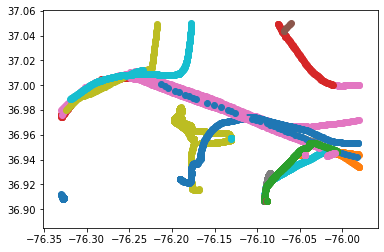

In [67]:
all_vessels = new_tracker.get_node_track()
for i in range(new_tracker.get_track_number()):
    track = all_vessels[i]
    temp_x = np.zeros(len(track))
    temp_y = np.zeros(len(track))
    counter = 0
    for element in track:
        temp_x[counter] = element.get_LON()
        temp_y[counter]= element.get_LAT()
        counter += 1
    x = np.array(temp_x)
    y = np.array(temp_y)
    plt.scatter(x,y)

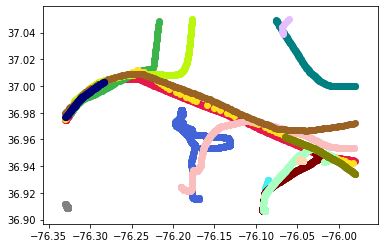

In [69]:
#Glimpse at all the vessel tracks
cnames = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000','#101010','#202020','#303030','#404040','#505050','#606060','#707070','#909090']
for vid in range(low_bound, high_bound+1):
    sample = dataset[dataset.VID == vid]
    temp_x = [element.LAT for element in sample.itertuples()]
    temp_y = [element.LON for element in sample.itertuples()]
    x = np.array(temp_x)
    y = np.array(temp_y)
    plt.scatter(y,x, c = cnames[vid-low_bound])

In [70]:
result = new_tracker.get_tracks()
expect = tracker.get_tracks()
accuracies = []
for every_expect in expect:
    max_accuracy = 0
    count = 0
    for every_track in result:
        for every_node in every_expect:
            if every_node in every_track:
                count += 1
        accuracy = count / len(every_expect)
        count = 0
        if(accuracy > max_accuracy):
            max_accuracy = accuracy
    accuracies.append(max_accuracy)
            

In [71]:
print(accuracies)
print(sum(accuracies)/len(accuracies))

[0.648881239242685, 0.8503937007874016, 0.5945945945945946, 0.9954430379746836, 0.8113619810633649, 0.5384024577572964, 0.3216867469879518, 0.5095638867635807, 0.9876237623762376, 1.0, 0.7486338797814208, 0.7272727272727273, 1.0, 0.2535211267605634, 0.3315571343990527, 0.582256169212691, 0.5086705202312138, 0.7096774193548387, 1.0, 0.896774193548387]
0.7008157289054344
